1. Setup

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.random_projection import GaussianRandomProjection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

2. Data Loading

In [66]:
batch_size = 32

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())

test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

3. Baseline Model

In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.fc1 = nn.Linear(576, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



4. Training and Evaluation Utilities

In [68]:
def train(dataloader, model, loss_fn, optimizer, log_interval, device, global_steps):
    size = len(dataloader.dataset)
    model.train()
    optimizer.zero_grad()
    accuracies = []
    losses = []
    steps = []
    current_accuracy = 0
    current_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % log_interval == 0:
            global_steps += 1
            current_loss = loss.item()
            current_accuracy = (pred.argmax(1) == y).type(torch.float).sum().item() / y.size(0)

            accuracies.append(current_accuracy)
            losses.append(current_loss)
            steps.append(global_steps)

    return losses, accuracies, steps, global_steps


In [69]:
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    

    return test_loss, correct

In [70]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

5. Subset Selection Utilities

In [71]:
def grad_per_sample(dataloader, model, loss_fn, device):

    model.train()

    grads = []

    projector = GaussianRandomProjection(n_components=500)
    temp_grads = []

    
    for idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        for i in range(len(y)):
            model.zero_grad()
            loss[i].backward(retain_graph=True)
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

            grad_vector = []
            for param in model.parameters():
                if param.grad is not None:
                    grad_vector.append(param.grad.view(-1))
            grad_vector = torch.cat(grad_vector).detach().numpy()

            norm = np.linalg.norm(grad_vector)
            if norm > 0:
                grad_vector = grad_vector / norm

            temp_grads.append(grad_vector)

            if len(temp_grads) >= 100: 
                break

    projector.fit(np.vstack(temp_grads))

    for idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        for i in range(len(y)):
            model.zero_grad()

            loss[i].backward(retain_graph=True)

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

            grad_vector = []
            for param in model.parameters():
                if param.grad is not None:
                    grad_vector.append(param.grad.view(-1))
            grad_vector = torch.cat(grad_vector).detach().numpy()
            grad_vector = grad_vector / np.linalg.norm(grad_vector)
            grad_vector = projector.transform(grad_vector.reshape(1, -1)).squeeze(0)
            grads.append(grad_vector)

    grads = np.vstack(grads)
    return grads

In [72]:
def kmeans_clustering(grad_array, num_clusters):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size = 1600)
    kmeans.fit(grad_array)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return centroids, labels

In [73]:
def subset_selection(grad_array, centroids, labels, subset_size):
    selected_idx = []

    num_to_select = max(1, subset_size // len(centroids))

    for cluster_idx in range(len(centroids)):
        cluster_points = np.where(labels == cluster_idx)[0]

        if len(cluster_points) == 0:
            continue
            
        num_to_select_in_cluster = min(num_to_select, len(cluster_points))
        distances = np.linalg.norm(grad_array[cluster_points] - centroids[cluster_idx], axis=1)
        closest_idx = np.argsort(distances)[:num_to_select_in_cluster]
        selected = cluster_points[closest_idx]

        selected_idx.extend(selected.tolist())

    return selected_idx

6. Evaluation



In [74]:
lr = 0.005
num_clusters = 10
epochs = 50
subset_update_freq = 5
N = len(train_dataset)
subset_size  = int(N * 0.1)

base_net = NeuralNetwork()
coreset_net = NeuralNetwork()
base_net, coreset_net = base_net.to(device), coreset_net.to(device)

loss_function = nn.CrossEntropyLoss()
grads_loss_function = nn.CrossEntropyLoss(reduction="none")
base_optimizer = optim.SGD(base_net.parameters(), lr=lr)
coreset_optimizer = optim.SGD(coreset_net.parameters(), lr=lr)

subset_dataloader = train_dataloader
random_subset_dataloader = train_dataloader

base_train_losses = []
base_train_accuracies = []
coreset_train_losses = []
coreset_train_accuracies = []

base_test_losses = []
base_test_accuracies = []
coreset_test_losses = []
coreset_test_accuracies = []

global_base_steps = []
global_coreset_steps = []

global_base_step = 0
global_coreset_step = 0

for epoch in range(epochs):
    base_train_loss, base_train_accuracy, base_steps, global_base_step = train(random_subset_dataloader, base_net, loss_function, base_optimizer, log_interval=100, device=device, global_steps=global_base_step)
    coreset_train_loss, coreset_train_accuracy, coreset_steps, global_coreset_step = train(subset_dataloader, coreset_net, loss_function, coreset_optimizer, log_interval=100, device=device, global_steps=global_coreset_step)

    base_test_loss, base_test_accuracy = evaluate(test_dataloader, base_net, loss_function, device)
    coreset_test_loss, coreset_test_accuracy = evaluate(test_dataloader, coreset_net, loss_function, device)

    base_train_losses.extend(base_train_loss)
    base_train_accuracies.extend(base_train_accuracy)
    coreset_train_losses.extend(coreset_train_loss)
    coreset_train_accuracies.extend(coreset_train_accuracy)

    global_base_steps.extend(base_steps)
    global_coreset_steps.extend(coreset_steps)

    base_test_losses.append(base_test_loss)
    base_test_accuracies.append(base_test_accuracy)
    coreset_test_losses.append(coreset_test_loss)
    coreset_test_accuracies.append(coreset_test_accuracy)

    if epoch % subset_update_freq == 0:
        random_idx = torch.randperm(N)[:subset_size].tolist()
        random_subset_dataset = Subset(train_dataset, random_idx)
        random_subset_dataloader = DataLoader(random_subset_dataset, batch_size=batch_size, shuffle=True)

        grad_array = grad_per_sample(subset_dataloader, coreset_net, grads_loss_function, device)
        centroids, labels = kmeans_clustering(grad_array, num_clusters)
        subset_idx = subset_selection(grad_array, centroids, labels, subset_size)

        subset_dataset = Subset(train_dataset, subset_idx)
        subset_dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)


7. Visualization

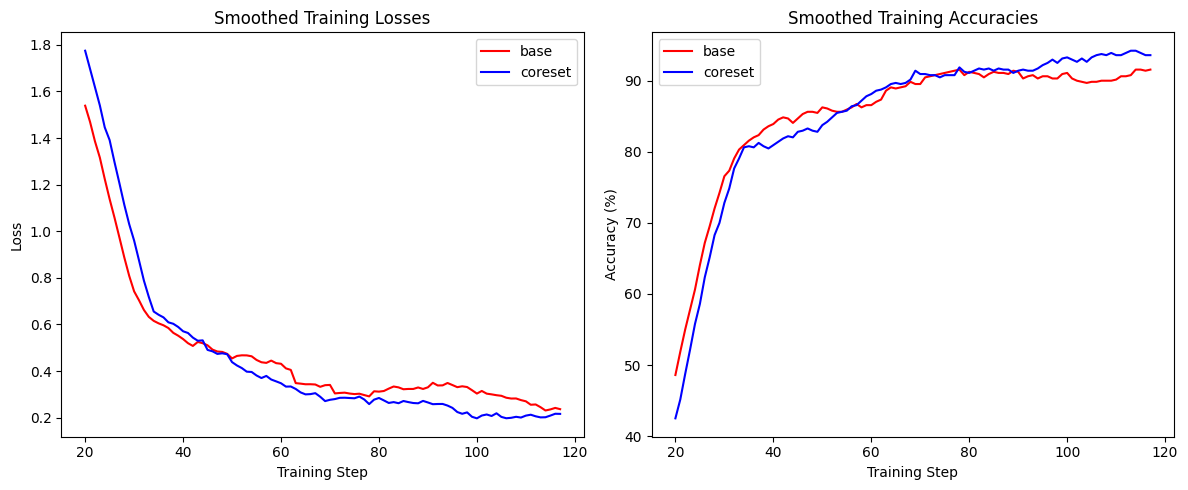

Base Test Error: 
 Accuracy: 95.7%, Avg loss: 0.145826 

Coreset Test Error: 
 Accuracy: 94.5%, Avg loss: 0.182289 



In [75]:

window_size = 20

smoothed_base_losses = moving_average(base_train_losses, window_size=20)
smoothed_base_accuracies = moving_average(base_train_accuracies, window_size=20)
smoothed_coreset_losses = moving_average(coreset_train_losses, window_size=20)
smoothed_coreset_accuracies = moving_average(coreset_train_accuracies, window_size=20)

base_indices = global_base_steps[window_size - 1:]
coreset_indices = global_coreset_steps[window_size - 1:]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(base_indices, smoothed_base_losses, color="r", label="base")
plt.plot(base_indices, smoothed_coreset_losses, color="b", label="coreset")
plt.title('Smoothed Training Losses')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(base_indices, [acc * 100 for acc in smoothed_base_accuracies], color="r", label="base")
plt.plot(base_indices, [acc * 100 for acc in smoothed_coreset_accuracies], color="b", label="coreset")
plt.title('Smoothed Training Accuracies')
plt.xlabel('Training Step')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


base_loss, base_correct = evaluate(test_dataloader, base_net, loss_function, device)
coreset_loss, coreset_correct = evaluate(test_dataloader, coreset_net, loss_function, device)

print(f"Base Test Error: \n Accuracy: {(100*base_correct):>0.1f}%, Avg loss: {base_loss:>8f} \n")
print(f"Coreset Test Error: \n Accuracy: {(100*coreset_correct):>0.1f}%, Avg loss: {coreset_loss:>8f} \n")

